In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


from collections import Counter, defaultdict
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import warnings
import pickle
import json

from src.lightbgm_model import train_lightgbm
from src.xgboost_model import train_xgboost
from src.catboost_model import train_catboost
from src.data_loader import load_data_with_scaling_and_encoding



# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
train, test = load_data_with_scaling_and_encoding()

Mem. usage decreased to 1044.70 Mb (46.6% reduction)
Mem. usage decreased to 895.89 Mb (46.5% reduction)


In [3]:
# Prepare features and target
X = train.drop(columns=['isFraud', 'TransactionID'])
y = train['isFraud']
X_test = test.drop(columns=['isFraud', 'TransactionID'], errors='ignore')

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
print ('start lightgbm')
lgb_model, s = train_lightgbm(X, y)

print ('start xgboost')
xgb_model = train_xgboost(X_train, y_train, X_val, y_val)

print ('start catboost')
cat_model = train_catboost(X_train, y_train, X_val, y_val)

start lightgbm
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid auc: 0.940162 + 0.00114276
[200]	cv_agg's valid auc: 0.950072 + 0.0020856
[300]	cv_agg's valid auc: 0.954726 + 0.00211515
[400]	cv_agg's valid auc: 0.957818 + 0.00204113
[500]	cv_agg's valid auc: 0.960203 + 0.00221721
[600]	cv_agg's valid auc: 0.962033 + 0.00213305
[700]	cv_agg's valid auc: 0.963551 + 0.00199519
[800]	cv_agg's valid auc: 0.964804 + 0.00201157
[900]	cv_agg's valid auc: 0.965835 + 0.00189526
[1000]	cv_agg's valid auc: 0.966577 + 0.00184547
Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid auc: 0.966577 + 0.00185021
start xgboost
[0]	validation_0-auc:0.78137	validation_1-auc:0.78052
[100]	validation_0-auc:0.91445	validation_1-auc:0.90641
[200]	validation_0-auc:0.93053	validation_1-auc:0.92052
[300]	validation_0-auc:0.94088	validation_1-auc:0.92917
[400]	validation_0-auc:0.94822	validation_1-auc:0.93478
[500]	validation_0-auc:0.95336	validation_1-auc:0.93886

# Analysis
## Out-of-Fold (OOF) Prediction and Evaluation

In [5]:
categorical_features = [
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_33', 'id_34', 'DeviceType', 'DeviceInfo'
]

DTYPE = {
    'TransactionID': 'int32',
    'isFraud': 'int8',
    'TransactionDT': 'int32',
    'TransactionAmt': 'float32',
    'ProductCD': 'category',
    'card1': 'int16',
    'card2': 'float32',
    'card3': 'float32',
    'card4': 'category',
    'card5': 'float32',
    'card6': 'category',
    'addr1': 'float32',
    'addr2': 'float32',
    'dist1': 'float32',
    'dist2': 'float32',
    'P_emaildomain': 'category',
    'R_emaildomain': 'category',
}

DTYPE_ID = {
    'TransactionID': 'int32',
    'DeviceType': 'category',
    'DeviceInfo': 'category',
}

train_transaction = pd.read_csv('dataset/train_transaction.csv',dtype=DTYPE)
train_identity = pd.read_csv('dataset/train_identity.csv',dtype=DTYPE_ID)
uni = train_transaction.merge(train_identity, how='left', on='TransactionID')


In [6]:
OOF = s.get_oof(X.shape[0])
roc_auc_score(y, OOF)

0.9665166417814709

<Axes: title={'center': 'Histogram of predictions'}, ylabel='Frequency'>

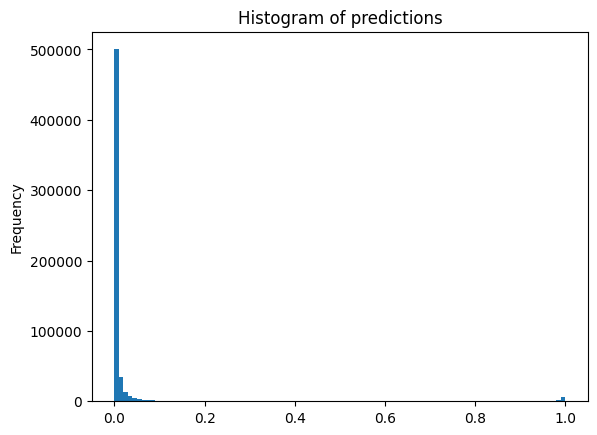

In [7]:
pd.Series(OOF).plot.hist(bins=100, title='Histogram of predictions')

## Observing the trend of predictions

<Axes: title={'center': 'Smoothed OOF prediction'}>

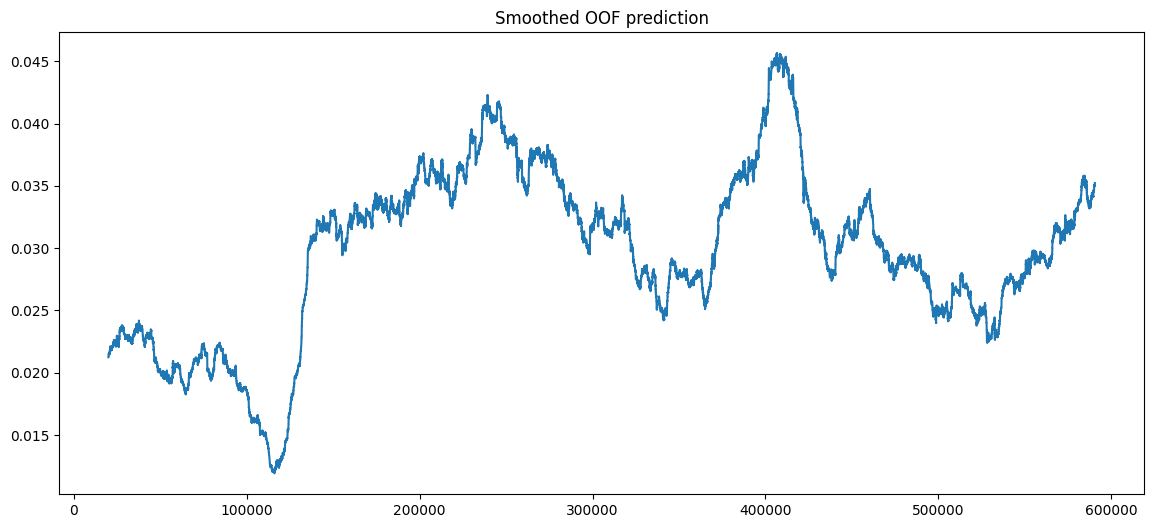

In [8]:
pd.Series(OOF).rolling(20000).mean().plot(figsize=(14,6), title='Smoothed OOF prediction')

## Examine the prediction distribution specifically for the training samples.

<Axes: title={'center': 'Histogram of predictions - train set rows'}, ylabel='Frequency'>

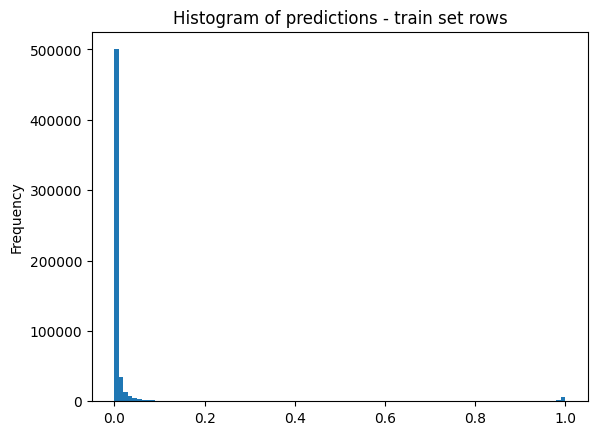

In [9]:
NTRAIN = 590540
pd.Series(OOF[:NTRAIN]).plot.hist(bins=100, title='Histogram of predictions - train set rows')

## Adversarial AUC Logs Visualization
 - plots the training and validation AUC logs to visualize model performance over time.
 - track the model's AUC performance during both the training and validation phases.

<Axes: title={'center': 'Adversarial AUC Logs'}>

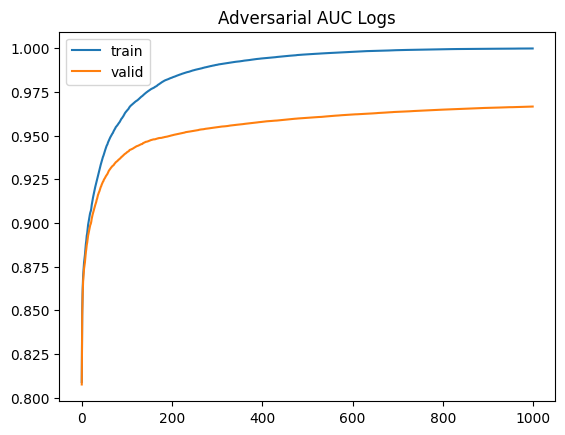

In [10]:
logs = pd.DataFrame({'train':s.train_log().mean(1), 'valid':s.valid_log().mean(1)})
logs.train.plot(legend=True, title='Adversarial AUC Logs')
logs.valid.plot(legend=True)

## Feature Importance Calculation and Visualization
identifying the most important features in the model based on both the gain and the number of splits used.


In [11]:
def make_importances(clf, importance_type):
    return pd.Series(data=clf.feature_importance(importance_type), index=clf.feature_name())

IMPORTANCES = pd.concat([make_importances(b, 'gain') for b in s.model.boosters], axis=1).sum(axis=1).to_frame('Gain')
IMPORTANCES['Count'] = pd.concat([make_importances(b, 'split') for b in s.model.boosters], axis=1).sum(axis=1)

IMPORTANCES.sort_values('Gain', ascending=False).head()


,Gain,Count
V258,205833.006647,151
C1,117416.299916,2841
TransactionDT,103082.192890,15816
card1,102398.741335,14490
C14,92975.933392,2405


In [12]:
# Save feature importance results
IMPORTANCES.to_csv("models/feature_importances.csv")

## Feature Importance Visualization
- Visually identifying the most important features with the highest 'Gain' importance
- Providing insight into which features are contributing the most to the model's decision-making process.

<Axes: title={'center': 'Adversarial Feature Gain'}>

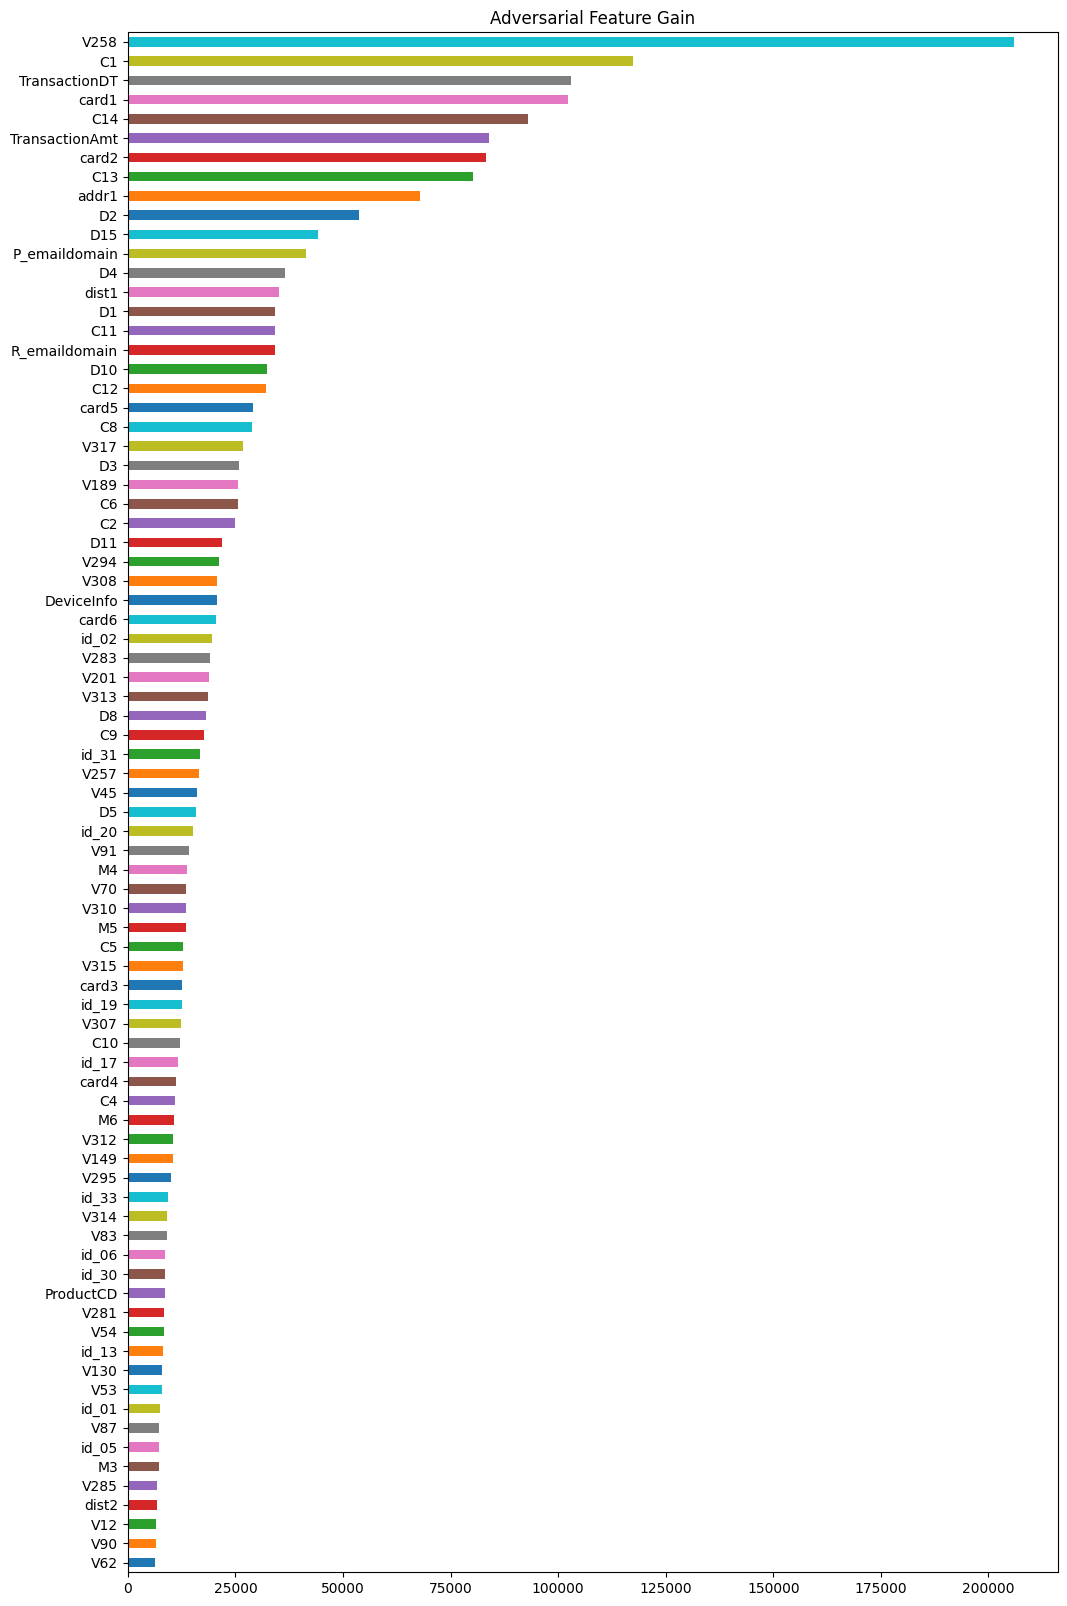

In [13]:
COLORS = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
toplot = IMPORTANCES.sort_values('Gain').tail(80)
toplot['Gain'].plot.barh(figsize=(12,20), color=COLORS, title='Adversarial Feature Gain')

## Split Point Statistics for Features
- compute statistics related to the split points in the trees for the model
- detailed analysis of how the model splits based on specific features
- for understanding which split points are most frequently used

In [14]:
def get_split_point_stats_multi(clfs):
    split_points = defaultdict(Counter)

    def visit_node(d):
        if 'tree_info' in d:
            for tree in d['tree_info']: # a list of trees
                visit_node(tree)
        for k in ['tree_structure', 'left_child', 'right_child' ]:
            if k in d:
                visit_node(d[k])
        if 'split_feature' in d:
            split_points[names[d['split_feature']]] [d['threshold']] += d['split_gain']

    for clf in clfs:
        names = clf.feature_name()
        visit_node(clf.dump_model())
    return split_points

split_points = get_split_point_stats_multi(s.model.boosters)

with open("models/split_points.json", "w") as f:
    json.dump({k: dict(v) for k, v in split_points.items()}, f)


## Plotting Adversarial Split Points for a Feature
 - helps in understanding How frequently a feature is split.
 - Which values contribute the most to the model’s decision-making.
 - The distribution of gain across different split values.

In [15]:
MAX_SHOW = 50
ADJS = 'abundant:common:ubiquitous:omnipresent:rampant:rife:permeant:widespread:legendary:popular:fashionable:frequent:usual:useful:predominant:recurrent:repetitive:repetitious:marked:prevalent:prevalent:prevalent'.split(':')

np.random.seed(42)

def plot_it(col):
    counts = split_points[col]
    ser = pd.Series(dict(counts)).sort_values(ascending=False)
    total_gain = IMPORTANCES.loc[col, 'Gain']
    total_splits = IMPORTANCES.loc[col, 'Count']
    if hasattr(uni[col], 'cat'):
        # remap categories from int -> cat value
        try:
            ser.index = uni[col].cat.categories[ser.index.astype(int)]
        except:
            # e.g. TypeError: Cannot cast Index to dtype <class 'int'>
            # a categorical with many categories and '1||4||7' etc type splits
            # leave it as it is
            pass
    adj = np.random.choice(ADJS)
    display(
        HTML(
            f'<h1 id="plot_{col}">{col}</h1>'
            f'<p>Used {total_splits} times, total gain is {total_gain}.'
            f'<p>{len(ser)} split point values used. '
            f'Most {adj} is {ser.index[0]} with gain of {ser.values[0]}.'
        )
    )
    ser = ser.head(MAX_SHOW).sort_index()
    ax = ser.plot.bar(title=f'{col} — Adversarial split points by gain',
                      rot=90, fontsize=12, figsize=(15,5),
                      width=0.7, color=COLORS)
    plt.show()

## Batch Visualization of Adversarial Split Points
### Analyzing feature importance across all input variables by visualizing which split points are the most impactful.

In [ ]:
for col in uni.columns.tolist():
    counts = split_points[col]
    if len(counts) >= 2:
        plot_it(col)